# Predicting Song Popularity#

## Key Takeaways ##

- **We constructed a logistic model to predict whether or not a song will reach the top 10 on the Billboard Hot 100 chart.**


- **Results summary stats from our model were counterintuitive insofar as predictors including key, timesignature, and tempo were statistically irrelevant, while variables pertaining to one's ability to esitmate these values for a song were highly significant.**


- **Nebulous "timbre" (i.e., music tone and/or quality) variables also proved highly significant, however, there was no discernable patterns among the coefficients.**


- **Two models easily beat the baseline model's accuracy rate (84.18%) and stood out as our best candidates: logistic3 and logistic_x. Logistic3's AIC was 4848.7 and its accuracy was 87.94%. The AUC for the model was .849 greatly exceeding the .5 benchmark. Logistic3 could best be characterized as a conservative model with a low sensitivity (32.2%) and high specificity of (98.4%).**


- **We produced Logistic_x by removing statistically insignificant variables from Logistic3. In doing so, we saw slight improvements in both AIC (-.0001%) and AUC (+.0082). The second model favored specificity over sensitivity by a slightly wider margin, thus making it even more conservative than the first.****


### Background Information ###

"The music industry has a well-developed market with a global annual revenue around $15 billion. The recording industry is highly competitive and is dominated by three big production companies which make up nearly 82% of the total annual album sales.

Artists are at the core of the music industry and record labels provide them with the necessary resources to sell their music on a large scale. A record label incurs numerous costs (studio recording, marketing, distribution, and touring) in exchange for a percentage of the profits from album sales, singles and concert tickets.

Unfortunately, the success of an artist's release is highly uncertain: a single may be extremely popular, resulting in widespread radio play and digital downloads, while another single may turn out quite unpopular, and therefore unprofitable.

Knowing the competitive nature of the recording industry, record labels face the fundamental decision problem of which musical releases to support to maximize their financial success."

(source: MITx)

### The Problem ###

Can data analytics predict the popularity of a song? Here, we endeavor to predict whether a song will garner a top 10 spot on the Billboard Hot 100 Chart.

### The Data ###

Our dataset consists of 1) all songs that made it into the top 10 of the Billboard Hot 100 from 1990-2010 and 2) a sampling of songs that failed to do so. The data were culled from three sources: Wikipedia, Billboard.com, and EchoNest.

We will predict song popularity as a function of its properties. The variables included in the dataset either describe the artist or the song. The specific variables are as follows:

**year**: the year the song was released

**songtitle**: the title of the song

**artistname**: the name of the artist of the song

**songID and artistID**: identifying variables for the song and artist

**timesignature and timesignature_confidence**: a variable estimating the time signature of the song, and the confidence in the estimate

**loudness**: a continuous variable indicating the average amplitude of the audio in decibels

**tempo and tempo_confidence**: a variable indicating the estimated beats per minute of the song, and the confidence in the estimate

**key and key_confidence**: a variable with twelve levels indicating the estimated key of the song (C, C#, . . ., B), and the confidence in the estimate

**energy**: a variable that represents the overall acoustic energy of the song, using a mix of features such as loudness

**pitch**: a continuous variable that indicates the pitch of the song

**timbre_0_min, timbre_0_max, timbre_1_min, timbre_1_max, . . . , timbre_11_min, and timbre_11_max**: variables that indicate the minimum/maximum values over all segments for each of the twelve values in the timbre vector (resulting in 24 continuous variables)

**Top10**: a binary variable indicating whether or not the song made it to the Top 10 of the Billboard Hot 100 Chart (1 if it was in the top 10, and 0 if it was not)

(source: MITx)

In [29]:
install.packages("corrplot")
install.packages("tidyverse")
install.packages("caTools")
install.packages("ROCR")
install.packages("ggthemes")
suppressPackageStartupMessages(library(caTools))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(ROCR))
suppressPackageStartupMessages(library(ggthemes))

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [2]:
songs = read.csv('songs.csv')

### Data Structure ###

In [3]:
str(songs)

'data.frame':	7574 obs. of  39 variables:
 $ year                    : int  2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 ...
 $ songtitle               : Factor w/ 7141 levels "̈́ l'or_e des bois",..: 6204 5522 241 3115 48 608 255 4419 2886 6756 ...
 $ artistname              : Factor w/ 1032 levels "50 Cent","98 Degrees",..: 3 3 3 3 3 3 3 3 3 12 ...
 $ songID                  : Factor w/ 7549 levels "SOAACNI1315CD4AC42",..: 595 5439 5252 1716 3431 1020 1831 3964 6904 2473 ...
 $ artistID                : Factor w/ 1047 levels "AR00B1I1187FB433EB",..: 671 671 671 671 671 671 671 671 671 507 ...
 $ timesignature           : int  3 4 4 4 4 4 4 4 4 4 ...
 $ timesignature_confidence: num  0.853 1 1 1 0.788 1 0.968 0.861 0.622 0.938 ...
 $ loudness                : num  -4.26 -4.05 -3.57 -3.81 -4.71 ...
 $ tempo                   : num  91.5 140 160.5 97.5 140.1 ...
 $ tempo_confidence        : num  0.953 0.921 0.489 0.794 0.286 0.347 0.273 0.83 0.018 0.929 ...
 $ key                   

### Data Summary ###

In [4]:
summary(songs)

      year          songtitle              artistname  
 Min.   :1990   Intro    :  15   Various artists: 162  
 1st Qu.:1997   Forever  :   8   Anal Cunt      :  49  
 Median :2002   Home     :   7   Various Artists:  44  
 Mean   :2001   Goodbye  :   6   Tori Amos      :  41  
 3rd Qu.:2006   Again    :   5   Eels           :  37  
 Max.   :2010   Beautiful:   5   Napalm Death   :  37  
                (Other)  :7528   (Other)        :7204  
                songID                   artistID    timesignature  
 SOALSZJ1370F1A7C75:   2   ARAGWS81187FB3F768: 222   Min.   :0.000  
 SOANPAC13936E0B640:   2   ARL14X91187FB4CF14:  49   1st Qu.:4.000  
 SOBDGMX12B0B80808E:   2   AR4KS8C1187FB4CF3D:  41   Median :4.000  
 SOBUDCZ12A58A80013:   2   AR0JZZ01187B9B2C99:  37   Mean   :3.894  
 SODFRLK13134387FB5:   2   ARZGTK71187B9AC7F5:  37   3rd Qu.:4.000  
 SOEJPOK12A6D4FAFE4:   2   AR95XYH1187FB53951:  31   Max.   :7.000  
 (Other)           :7562   (Other)           :7157                  


### Exploratory Data Analysis ###

The charts below tell may tell a more engaging story than what appears at first blush.  Our line chart indicates the number of songs available to be included in the Billboard Hot 100 varied significantly year-over-year, with a sizable uptick occurring post 2001. This seems to coincide with the transition from CDs to digitally stored music and the emergence of internet distribution, sharing (e.g., Napster), and streaming services.

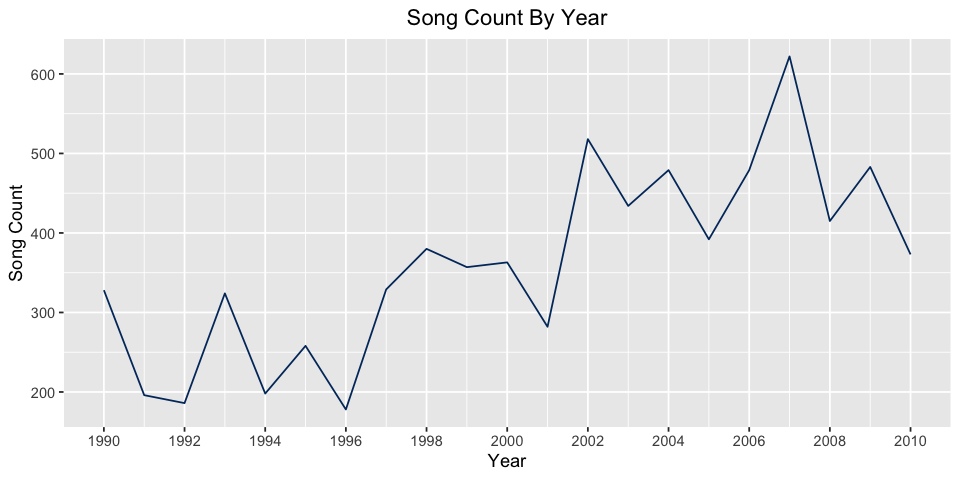

In [5]:
songs_by_year = songs %>%
    select(year) %>%
    group_by(year) %>%
    tally()
options(repr.plot.width=8, repr.plot.height=4)
ggplot(songs_by_year, aes(x = year, y = n)) + 
    geom_line(colour="#00356B") + 
    scale_x_continuous(breaks=seq(1990,2010,2)) +
    labs(x="Year", y="Song Count") +
    ggtitle("Song Count By Year") +
    theme(plot.title = element_text(hjust=.5))

This interpretation provides a plausible explanation for the trend revealed in our bar chart. As the number of songs entering the market increased, the percentage of songs reaching the Top 10 declined precipitously.

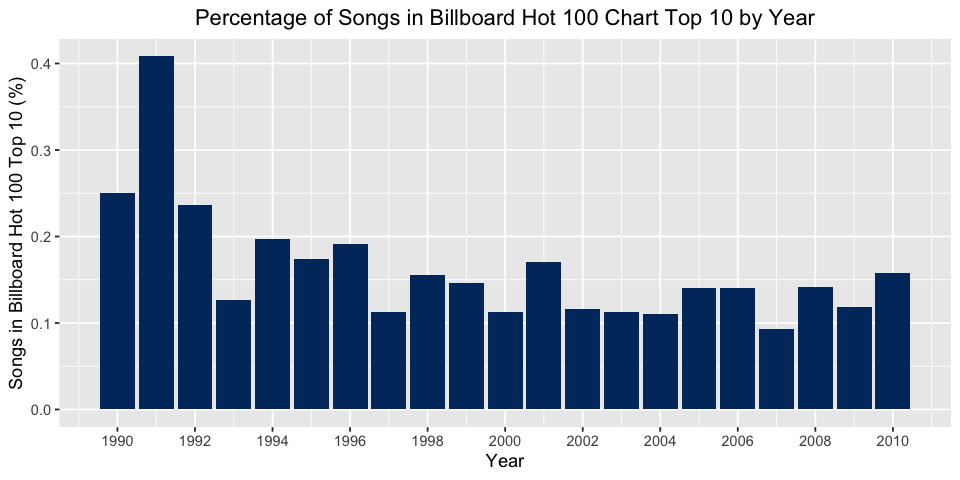

In [15]:
Pct_Top10_by_year = songs %>%
    group_by(year, Top10) %>%
    summarise (n = n()) %>%
    mutate(Percentage = n / sum(n)) %>%
    filter(Top10==1)
options(repr.plot.width=8, repr.plot.height=4)
ggplot(Pct_Top10_by_year, aes(x = year, y = Percentage)) + 
    geom_bar(stat='identity', fill="#00356B") +
    ggtitle("Percentage of Songs in Billboard Hot 100 Chart Top 10 by Year") +
    theme(plot.title = element_text(hjust=.5)) +
    xlab("Year") +
    ylab("Songs in Billboard Hot 100 Top 10 (%)") +
    scale_x_continuous(breaks=seq(1990,2010,2))

The phenomenon calls to mind theories of competitive markets.  After 2001, the internet lowered the barriers to entry for all artists to enter the marketplace with new songs. This increase in available songs naturally lead to a rise in competition for a spot on the Billboard Hot 100. Consequently, fewer titles charted in the Top 10, on a percentage basis.  Hence, the structure of the industry changed with respect to 1) the difficulty one faced entering the market and 2) the number distribution channels available to consumers of single titles or entire albums. The latter point is significant because making the Billboard Hot 100 is contingent not only on the frequency with which a song is played on the radio, but also online sales.

Performing the statistical tests required to prove or disprove this hypothesis is beyond the scope of this assignment, however, we offer it as an interesting theory worthy of further exploration.

<br>



Selecting by n


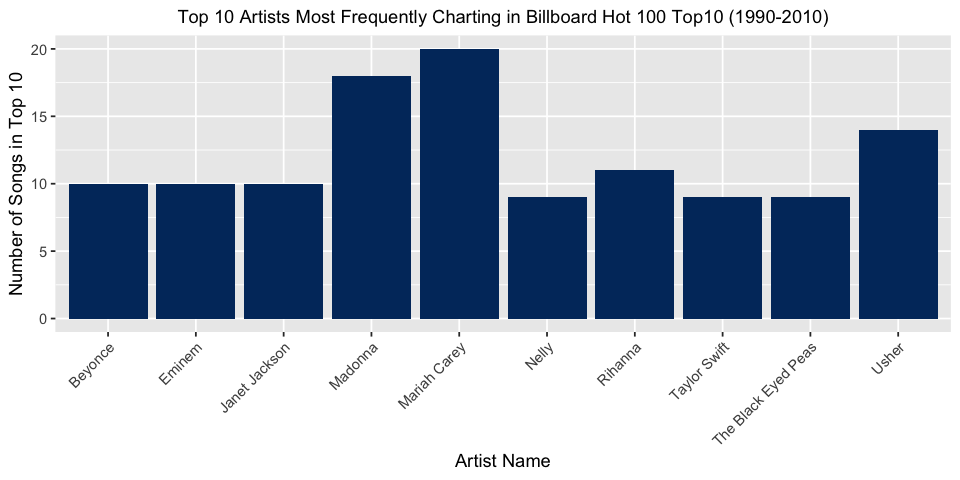

In [71]:
most_popular = songs %>%
    filter(Top10 == 1) %>%
    group_by(artistname) %>%
    tally(Top10) %>%
    top_n(10) %>%
    arrange(desc(n))
options(repr.plot.width=8, repr.plot.height=4)
ggplot(most_popular, aes(x = artistname, y = n)) + 
    geom_bar(stat='identity', fill="#00356B") +
    ggtitle("Top 10 Artists Most Frequently Charting in Billboard Hot 100 Top10 (1990-2010)") +
    theme(plot.title = element_text(size=11, hjust=.5)) +
    xlab("Artist Name") +
    theme(text = element_text(size=11), axis.text.x = element_text(angle=45, hjust=1)) +
    ylab("Number of Songs in Top 10") + 
    theme(text=element_text(size=11))

For certain artists, the paucity of top 10 hits is a function of the observation period. Consider the case of Michael Jackson. Jackson's first #1 hit on the Billboard Hot 100, "Ben," was released in 1971. He released successuful solo material while still singing with the Jackson 5. His success reached its zenith in the 80s and early 90s. Our data set, however, contains limited data on Jackson. Examine the following queries:

In [48]:
songs_MJ = table(songs$artistname=="Michael Jackson")[[2]]
cat(paste(songs_MJ, "songs in our data set were released by Michael Jackson."))

18 songs in our data set were released by Michael Jackson.

In [79]:
fastest_song=songs$songtitle[which.max(songs$tempo)]
fastest_artist=songs$artistname[which.max(songs$tempo)]
cat(paste("The song with the fastest tempo is ", "'",fastest_song,"'", "by ", fastest_artist, ".", sep=""))

The song with the fastest tempo is 'Wanna Be Startin' Somethin''by Michael Jackson.

We have only 18 songs by Michael Jackson in our data set. One of them happens to be the fastest! Furthermore, the table below indicates only five of these were top-ten hits for the "King of Pop." We are certain this number is artifically low due to the limited observation period. Our position can be easily confirmed by a review of his work on any number of industry and/or fan sites.

In [56]:
MJ_subset %>%
    select(year, songtitle, artistname, Top10) %>%
    filter(artistname == "Michael Jackson") %>%
    filter(Top10==1)


year songtitle         artistname      Top10
1 2001 You Rock My World Michael Jackson 1    
2 1995 You Are Not Alone Michael Jackson 1    
3 1995 Black or White    Michael Jackson 1    
4 1995 Remember the Time Michael Jackson 1    
5 1992 In The Closet     Michael Jackson 1

The key takeaway here is an important one in any statistical, data analytics, or ML endeavor: the number of top 10 hits by any artist in our data set is neither an adequate proxy for overall career popularity, nor the number of top 10 hits the artist attained during his/her working life. This represents a limitation of the data that must be kept in mind.
<br>

We calculated average values for timesignature, loudness, tempo, key, energy, and pitch -- across all years in the obeservation period -- for titles appearing in the top 10 performed by those artists (listed above) whose songs most frequently appeared in the top 10, all top 10 songs in general, and all songs in our data set. Our objective was discern what, if any, differences existed among the three groups. 

Certain trends are evident as we move from one cohort to another. All three groups tend to use the 4 timesignature, a tempo of approximately 107, and a key in the vicinity of 5.5. Differences of note are that 1) as energy increases, loudness also increases (i.e., becomes less negative), 2) the average top 10 song tends to be of lower pitch than songs appearing in other positions on the chart, and 3) while the mean timbre_0_min is higher for top 10 songs, the timbre_0_max is lower. 

In [61]:
data_popular_songs_only = songs %>%
    select(-one_of('songtitle', 'songID', 'artistID')) %>%
    filter(artistname %in% c("Mariah Carey", "Madonna", "Usher", "Rihanna", "Beyonce", "Eminem", "Janet Jackson", "Nelly", "Taylor Swift", "The Black Eyed Peas")) %>%
    filter(Top10==1)
mean_data_top_songs = data_popular_songs_only %>%
    select("year","timesignature","timesignature_confidence","loudness","tempo","tempo_confidence","key","key_confidence","energy","pitch","timbre_0_min","timbre_0_max", -one_of('artistname')) %>%
    group_by(year) %>%
    summarise_each(mean)
top_songs_summary1 = mean_data_top_songs %>% 
    select("timesignature", "loudness", "tempo", "key", "energy", "pitch","timbre_0_min","timbre_0_max", -one_of('year')) %>%
    summarise_each(mean)
top_songs_summary1

timesignature loudness  tempo    key      energy    pitch       timbre_0_min
1 3.937458      -10.35751 107.8422 5.752962 0.5699275 0.005355971 4.038865    
  timbre_0_max
1 52.18967

In [62]:
songs_all_Top10 = songs %>%
    select("year","timesignature","timesignature_confidence","loudness","tempo","tempo_confidence","key","key_confidence","energy","pitch","timbre_0_min","timbre_0_max","Top10", -one_of('artistname')) %>%
    filter(Top10==1) %>%
    group_by(year) %>%
    summarise_each(mean)
songs_all_summary_Top10 = songs_all_Top10 %>% 
    select("timesignature", "loudness","tempo", "key", "energy", "pitch", "timbre_0_min", "timbre_0_max", -one_of('year', "Top10")) %>%
    summarise_each(mean)
songs_all_summary_Top10

timesignature loudness  tempo    key      energy    pitch      timbre_0_min
1 3.944994      -9.777631 107.0942 5.661201 0.6013598 0.00616036 5.715436    
  timbre_0_max
1 52.93576

In [63]:
songs_all = songs %>%
    select("year", "timesignature", "timesignature_confidence", "loudness", "tempo", "tempo_confidence", "key", "key_confidence", "energy", "pitch", "timbre_0_min", "timbre_0_max", -one_of('artistname')) %>%
    group_by(year) %>%
    summarise_each(mean)
songs_all_summary1 = songs_all %>% 
    select("timesignature", "loudness", "tempo", "key", "energy", "pitch", "timbre_0_min", "timbre_0_max", -one_of('year')) %>%
    summarise_each(mean)
songs_all_summary1

timesignature loudness  tempo    key      energy    pitch      timbre_0_min
1 3.893903      -9.143321 107.2109 5.425689 0.6682055 0.01094864 3.93193     
  timbre_0_max
1 54.19077

Our correlation matrix confirms that there is a relationship exists between energy and loudness. Quite unexpectedly, both loudness and energy are positively correlated with timbre_0_max. Prior to finalizing any model, we must correct for this instance of multicolinearity. 

In [74]:
cols = c(names(songs)[6:38])
corr_subset = songs %>%
    select(cols)

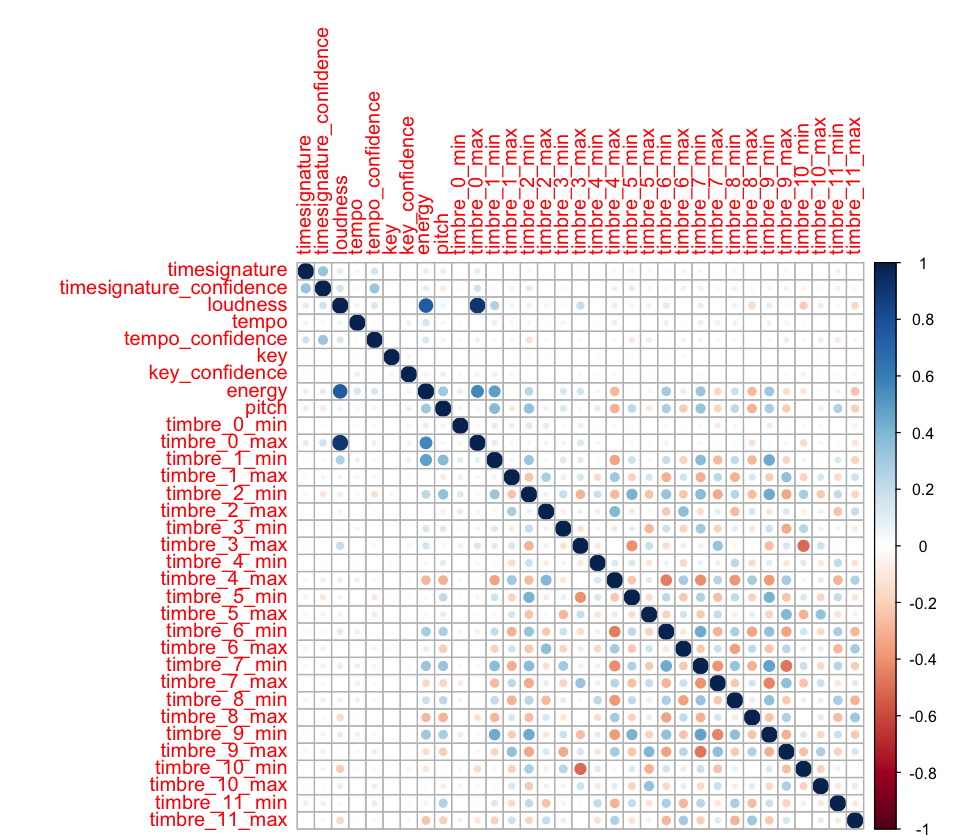

In [75]:
options(repr.plot.width=8, repr.plot.height=7)
corrplot(cor(corr_subset, use="complete.obs"))

We will leave let our model tell us more about the multitude of timbre variables in our data set. This is a nuanced concept that is difficult to both define and discuss, and we have many questions for the individuals compiling the data concerning how they operationalized this variable.

### The Models###

Our response variable is a binary classification. Hence, a logistic regression framework is a reasonable choice for modeling whether or not a song will be in the Top10.

As per usual, we start by splitting our data into training and test sets. Our training set will contain all songs released up to 2009 (inclusive). Tracks released uring 2010 will comprise our test set. This will result in an 85/15 split in the response variable across both data sets.

In [101]:
train = subset(songs, year <= 2009)
test = subset(songs, year == 2010)

The model will include only those variables that describe the numerical properties of the songs in our dataset.

In [94]:
exclusions = c('year', 'songtitle', 'artistname', 'songID', 'artistID')
train2 = train[,!(names(train)%in% exclusions)]
test2 = test[,!(names(test) %in% exclusions)]

Our model, which we conditioned on all variables in our training set, is presented below, followed by summary statistics.

In [104]:
logistic1 = glm(Top10 ~ ., data=train2, family=binomial)

In [103]:
summary(logistic1)


Call:
glm(formula = Top10 ~ ., family = binomial, data = train2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9220  -0.5399  -0.3459  -0.1845   3.0770  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)               1.470e+01  1.806e+00   8.138 4.03e-16 ***
timesignature             1.264e-01  8.674e-02   1.457 0.145050    
timesignature_confidence  7.450e-01  1.953e-01   3.815 0.000136 ***
loudness                  2.999e-01  2.917e-02  10.282  < 2e-16 ***
tempo                     3.634e-04  1.691e-03   0.215 0.829889    
tempo_confidence          4.732e-01  1.422e-01   3.329 0.000873 ***
key                       1.588e-02  1.039e-02   1.529 0.126349    
key_confidence            3.087e-01  1.412e-01   2.187 0.028760 *  
energy                   -1.502e+00  3.099e-01  -4.847 1.25e-06 ***
pitch                    -4.491e+01  6.835e+00  -6.570 5.02e-11 ***
timbre_0_min              2.316e-02  4.256e-03   5.441 5.

While there is a lot to unpack here, we would like to discuss four observations from the summary data presented.

First, though an ill-defined and otherswise slippery concept, eleven of our "timbre" variables are highly significant. There is not ostensible pattern, however, among them. 

Second, recall our earlier observations that both "chart toppers" and songs outside of the top 10, tended to use the 4 timesignature, a tempo of approximately 107, and a key in the vicinity of 5.5. Absent interaction effects with other variables, this implies timesignature, tempo, and key would not be of use when identifying tracks likely to make it to the top 10. Our results confirm this suspicion; none of the aforementioned variables were statistically significant.

Third, a fascinating discovery was that our "confidence" variables (i.e., key_confidence, timesignature_confidence, & tempo_confidence) lead to a higher likelihood a song landing in the top 10. Note that the confidence variables were based on the listener's ability to correctly identify each of several statistically insignificant variables. One interpretation is that our confidence variables speak to the listener's ability to make sense of the music with respect to key, time signature, and tone. Furthermore, the coefficients on our confidence variables are positive. If we are highly confident in our estimates of these song characteristics, then the song under consideration is likely fairly simple, and -- according to our model -- the probability it will land in the top 10 will increase with the value of the confidence variable(s). By contrast, when we are less certain about our estimates of a song's characteristics, it's likely to be more complex than many of its conterparts. The implication seems clear: Songs with lower levels of complexity are more likely to hit the top 10 than more complex tracks, where complexity is measured by the confidence with which they can estimate the title's key, tempo, and time signature.  

Fourth, songs with heavy instrumentation tend to be loud and energetic.  The coefficient for loudness supports the notion that listeners enjoy this trait. The coefficient for energy does not. This counterintuitive outcome, coupled with the results of our correlation plot above, suggests multicollinearity may be to blame. We will, therefore, take a closer look at the correlation between loudness and energy.

In [106]:
correl = cor(train2$loudness, train2$energy)
cat(paste("The correlation between 'loudness' & 'energy':", round(correl,4)))

The correlation between 'loudness' & 'energy': 0.7399

Multicollinearity is indeed at work within our model and either loudness or energy must go. We will eliminate loudness simply because loud songs are not necessarily good songs. 

In [107]:
logistic2 = glm(Top10 ~ . -loudness, data=train2, family=binomial)

In [108]:
summary(logistic2)


Call:
glm(formula = Top10 ~ . - loudness, family = binomial, data = train2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0983  -0.5607  -0.3602  -0.1902   3.3107  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -2.241e+00  7.465e-01  -3.002 0.002686 ** 
timesignature             1.625e-01  8.734e-02   1.860 0.062873 .  
timesignature_confidence  6.885e-01  1.924e-01   3.578 0.000346 ***
tempo                     5.521e-04  1.665e-03   0.332 0.740226    
tempo_confidence          5.497e-01  1.407e-01   3.906 9.40e-05 ***
key                       1.740e-02  1.026e-02   1.697 0.089740 .  
key_confidence            2.954e-01  1.394e-01   2.118 0.034163 *  
energy                    1.813e-01  2.608e-01   0.695 0.486991    
pitch                    -5.150e+01  6.857e+00  -7.511 5.87e-14 ***
timbre_0_min              2.479e-02  4.240e-03   5.847 5.01e-09 ***
timbre_0_max             -1.007e-01  1.178e-02

The removal of our 'loudness' variable from the model swung the coefficient for 'energy' in the right direction, however, it is no longer significant. Moreover, our AIC increased from 4827.2 to 4937.8. This indicates we now have an inferior model. We'll now see what happens when we retain our loudness variable and eliminate the energy feature. 

In [109]:
logistic3 = glm(Top10 ~ . -energy, data=train2, family=binomial)

In [110]:
summary(logistic3)


Call:
glm(formula = Top10 ~ . - energy, family = binomial, data = train2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9182  -0.5417  -0.3481  -0.1874   3.4171  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)               1.196e+01  1.714e+00   6.977 3.01e-12 ***
timesignature             1.151e-01  8.726e-02   1.319 0.187183    
timesignature_confidence  7.143e-01  1.946e-01   3.670 0.000242 ***
loudness                  2.306e-01  2.528e-02   9.120  < 2e-16 ***
tempo                    -6.460e-04  1.665e-03  -0.388 0.698107    
tempo_confidence          3.841e-01  1.398e-01   2.747 0.006019 ** 
key                       1.649e-02  1.035e-02   1.593 0.111056    
key_confidence            3.394e-01  1.409e-01   2.409 0.015984 *  
pitch                    -5.328e+01  6.733e+00  -7.914 2.49e-15 ***
timbre_0_min              2.205e-02  4.239e-03   5.200 1.99e-07 ***
timbre_0_max             -3.105e-01  2.537e-02 -

While our AIC increased marginally from 4827.2 to 4848.7, indicating a slight decline in model quality, removing the 'energy' term from the model eliminated our multicollinearity issue and left us with our highly significant 'loudness' variable. Thus, the slight increase in AIC seems worth it. 

### Out-of-Sample Testing ###

Below we predict over the test set, present our confusion matrix, and summary findings.

In [111]:
logistic3_pred = predict(logistic3, newdata=test2, type='response')

In [112]:
confusion_mtx = function(df, observed_y, predicted_y, threshold) {
    
    # Input: dataframe, response variable name as string, vector of 
    # predicted values, threshold value
    # 
    # Output: Confusion matrix to assess model performance
    
    cmtx=table(df[[observed_y]], predicted_y > threshold)
    
    return (cmtx)
}


The following is our confusion matrix and summary data obtained therefrom

In [126]:
cmtx=confusion_mtx(test2, 'Top10', logistic3_pred, .45)
addmargins(cmtx)

FALSE TRUE Sum
  0   309    5   314
  1    40   19    59
  Sum 349   24   373

In [127]:
confusion_accuracy = function(confusion_matrix) {
    
    # Input: confusion matrix
    #
    # Output: Message stating the accuracy of the model based on the data
    # contained in the matrix.
    
    accuracy = sum(diag(prop.table(confusion_matrix)))
    
    return (cat(paste("Based on the confusion matrix, the out-of-sample accuracy of our model is ", round(accuracy,4)*100, "%.", sep="")))
}

confusion_accuracy(cmtx)

Based on the confusion matrix, the out-of-sample accuracy of our model is 87.94%.

Our model's out-of-sample accuracy of 87.94% seems like a decent result, but how does it compare to the baseline prediction derived from the test set?

In [130]:
cat(paste("Our baseline model has an accuracy of", round(table(test2$Top10)[[1]]/(table(test2$Top10)[[1]]+table(test2$Top10)[[2]]),4)*100),"%.", sep="")

Our baseline model has an accuracy of 84.18%.

It looks like we definitely took a step in the right direction, as we've beaten the basline model. Further confirmation is provided by the model's AUC, which is significantly higher than the .5 benchmark. 

In [156]:
pred_3 = prediction(logistic3_pred, test$Top10)
cat(paste("The AUC value for our model is ",round(as.numeric(performance(pred_3, "auc")@y.values),4),".", sep=""))

The AUC value for our model is 0.849.

Below we display the sensitivity and specificty stats for our model, in addition to the helper functions we used to derive them. 

In [131]:
sensitivity = function(confusion_mtx) {
    #Input: 2x2 Confusion Matrix
    #
    #Output: The sensitivity/true positive rate of the matrix
    
    true_poz_rate = (confusion_mtx[[4]]/(confusion_mtx[[2]]+confusion_mtx[[4]]))
    return (true_poz_rate)
}

cat(paste("Our model has a sensitivity (true positive rate) of", round(sensitivity(cmtx),4)*100),"%.", sep="")

Our model has a sensitivity (true positive rate) of 32.2%.

In [132]:
specificity = function(confusion_mtx) {
    #Input: 2x2 Confusion Matrix
    #
    #Output: The specificity/true negative rate of the matrix
    
    true_neg_rate = (confusion_mtx[[1]]/(confusion_mtx[[1]]+confusion_mtx[[3]]))
    return (true_neg_rate)
}
cat(paste("Our model has a specificity (true negative rate) of", round(specificity(cmtx),4)*100),"%.", sep="")

Our model has a specificity (true negative rate) of 98.41%.

We are certain a record producer would prefer our model to the baseline. Not only do we outperform the baseline, recall that the baseline model predicts the most frequent outcome, which is that a song ****will not**** become a hit. This is not consistent with the objectives of most recording executives or artists.

Looking at the confusion matrix for our third model, we see it accurately predicts that 19 songs will be Top 10 hits and inaccurately predicts only 5 songs will be in the Top 10.  This represents a decisive improvement over the baseline model. Furthermore, the above results indicate our model favors specificity over sensitvity, implying our predictions are conservative at a threshold of .45. The model, therefore, should be quite useful to anyone seeking an edge over the baseline approach.  

### Beyond the Assignment: Can we do better? ###

In this section, we explore the possibility of improving both our model's quality and accuracy by eliminating statistically insignificant variables.

We begin with our third model and the elimination of statistically insignificant features starting with timbre features, and working our way up to more qualitatively relatable predictors. 

In [145]:
logistic_x = glm(Top10 ~ . -tempo -timesignature -energy -timbre_1_max -timbre_2_min -timbre_2_max -timbre_3_min -timbre_5_max -timbre_6_max -timbre_7_min -timbre_7_max -timbre_8_min -timbre_8_max -timbre_9_min -timbre_9_max -timbre_10_min, data=train2, family=binomial)

In [146]:
summary(logistic_x)


Call:
glm(formula = Top10 ~ . - tempo - timesignature - energy - timbre_1_max - 
    timbre_2_min - timbre_2_max - timbre_3_min - timbre_5_max - 
    timbre_6_max - timbre_7_min - timbre_7_max - timbre_8_min - 
    timbre_8_max - timbre_9_min - timbre_9_max - timbre_10_min, 
    family = binomial, data = train2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9833  -0.5475  -0.3537  -0.1884   3.4370  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)               1.285e+01  1.591e+00   8.076 6.71e-16 ***
timesignature_confidence  7.679e-01  1.880e-01   4.086 4.40e-05 ***
loudness                  2.343e-01  2.464e-02   9.510  < 2e-16 ***
tempo_confidence          4.305e-01  1.374e-01   3.133 0.001729 ** 
key                       1.737e-02  1.030e-02   1.686 0.091761 .  
key_confidence            3.247e-01  1.393e-01   2.330 0.019788 *  
pitch                    -5.797e+01  6.500e+00  -8.918  < 2e-16 ***
timbre_0_min

Our AIC for our revised model, logistic_x, is now slightly lower than our original logistic3, thus indicating an improvement in the overall quality of ur model. We have retained the key and key_confidence predictors, despite their low statistical significance. Their removal raises our AIC, and we are unwilling to cede additional ground on this front. 

In [147]:
logistic_x_pred = predict(logistic_x, newdata=test2, type='response')

Below we present summary statistics for our revised model.  Note that while there is no loss of accuracy and a minor gain in AUC, sensitivity has decreased and specificity has increased slightly. 

In [154]:
pred_x = prediction(logistic_x_pred, test$Top10)
cat(paste("The AUC value for our model is ",round(as.numeric(performance(pred_x, "auc")@y.values),4),".", sep=""))

The AUC value for our model is 0.8561.

In [148]:
cmtx=confusion_mtx(test2, 'Top10', logistic_x_pred, .45)
addmargins(cmtx)

FALSE TRUE Sum
  0   310    4   314
  1    41   18    59
  Sum 351   22   373

In [149]:
confusion_accuracy(cmtx)

Based on the confusion matrix, the out-of-sample accuracy of our model is 87.94%.

In [150]:
cat(paste("Our baseline model has an accuracy of", round(table(test2$Top10)[[1]]/(table(test2$Top10)[[1]]+table(test2$Top10)[[2]]),4)*100),"%.", sep="")

Our baseline model has an accuracy of 84.18%.

In [152]:
cat(paste("Our model has a sensitivity (true positive rate) of", round(sensitivity(cmtx),4)*100),"%.", sep="")

Our model has a sensitivity (true positive rate) of 30.51%.

In [153]:
cat(paste("Our model has a specificity (true negative rate) of", round(specificity(cmtx),4)*100),"%.", sep="")

Our model has a specificity (true negative rate) of 98.73%.

Our final model has much to recommend. We saw improvements in both AUC and AIC. Models with high predictive ability and few variables are almost always preferred to comparable models with relatively more variables. We admit to having a bias toward parsimony when building models. Our model, however, was built to assist record executives in making financial decisions, and not win logistic model aesthetics contest. When deciding which model to use, the slight decline in sensitivity would have to be weighed against the actual cost of potentiall missing an additional top 10 hit the predecessor model would have identified.